<a href="https://colab.research.google.com/github/pranjul6386/Swiggy_data_analysis/blob/main/swiggy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# Load in our libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import keras
import h5py
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization,Dropout
from tensorflow.keras.initializers import RandomNormal, Constant
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

In [5]:
#Load the two datsets using read_csv method of pandas
df_assign=pd.read_csv("/content/drive/MyDrive/Datasets/Swiggy_data/Assignment_Data.csv")
df_partner=pd.read_csv("/content/drive/MyDrive/Datasets/Swiggy_data/Delivery_Partners_Data.csv")

In [6]:

df_assign.head()


,ORDER_ID,DE_ID,ASSIGNMENT_START_TIME,ASSIGNMENT_END_TIME,reject_ind,reject_type,PLACED_TIME,DELIVERED_TIME,LASTMILE_DISTANCE,FIRSTMILE_DISTANCE,LAST_MILE_TIME_PREDICTED,PAYOUT_MADE_TO_DE,NUM_PING_COUNT_LAST10MIN,LAST_PING_TIME_LAST10MIN,CUSTOMER_ZONE,CUSTOMER_LAT,CUSTOMER_LNG
0,2745,180976,2021-02-13 03:08:24.000,2021-02-13 03:38:26.000,0,NaN,2021-02-13 03:01:11.686,2021-02-13 03:43:26.000,320.9,320.0,314.0,1810.0,63,2021-02-13 03:07:34.000,373.0,37.377569,72.832560
1,9462,280243,2021-02-14 05:06:40.000,2021-02-14 05:31:04.000,0,NaN,2021-02-14 04:54:25.832,2021-02-14 05:36:04.000,516.8,342.5,451.0,3210.0,27,2021-02-14 05:06:40.000,373.0,37.380613,72.796909
2,14071,339813,2021-02-15 02:22:40.000,2021-02-15 02:44:02.000,0,NaN,2021-02-15 02:01:17.864,2021-02-15 02:49:02.000,459.5,418.7,443.0,2910.0,57,2021-02-15 02:22:35.000,373.0,37.372032,72.805871
3,14442,1315348,2021-02-15 03:01:25.000,2021-02-15 03:15:02.000,0,NaN,2021-02-15 02:43:41.129,2021-02-15 03:20:02.000,376.4,332.9,367.3,3210.0,41,2021-02-15 03:00:28.000,373.0,37.371380,72.819992
4,14515,1186729,2021-02-15 03:12:24.000,2021-02-15 03:50:24.000,0,NaN,2021-02-15 02:48:17.074,2021-02-15 03:55:24.000,414.5,334.1,413.2,3210.0,13,2021-02-15 03:12:09.000,373.0,37.369925,72.826764


In [7]:
df_partner.head()

,DE_ID,SHIFT_END_TIME,DE_HOME_LAT,DE_HOME_LNG,DE_JOINING_DATE,DE_ZONE_ID
0,141533,06:42,37.390427,72.849424,2019-09-20,372
1,235942,08:42,37.372289,72.885341,2020-03-15,372
2,973234,06:42,37.410268,72.853610,2018-12-21,375
3,973473,05:42,37.397067,72.872533,2018-12-21,624
4,1016546,06:42,37.425545,72.895137,2019-01-11,668


In [8]:
#no null values in the de partner datset
df_partner.isnull().sum()
print(df_partner.shape)
df_partner=df_partner.drop(['DE_JOINING_DATE'],axis=1)

(991, 6)


In [9]:
#Inner join of two datasets on the common column "DE_ID"
df_final = df_assign.merge(df_partner, on="DE_ID", how = 'inner')
df_final.head()

,ORDER_ID,DE_ID,ASSIGNMENT_START_TIME,ASSIGNMENT_END_TIME,reject_ind,reject_type,PLACED_TIME,DELIVERED_TIME,LASTMILE_DISTANCE,FIRSTMILE_DISTANCE,LAST_MILE_TIME_PREDICTED,PAYOUT_MADE_TO_DE,NUM_PING_COUNT_LAST10MIN,LAST_PING_TIME_LAST10MIN,CUSTOMER_ZONE,CUSTOMER_LAT,CUSTOMER_LNG,SHIFT_END_TIME,DE_HOME_LAT,DE_HOME_LNG,DE_ZONE_ID
0,2745,180976,2021-02-13 03:08:24.000,2021-02-13 03:38:26.000,0,NaN,2021-02-13 03:01:11.686,2021-02-13 03:43:26.000,320.9,320.0,314.0,1810.0,63,2021-02-13 03:07:34.000,373.0,37.377569,72.832560,05:42,37.374634,72.871986,373
1,14974,180976,2021-02-15 03:36:24.000,2021-02-15 03:54:31.000,0,NaN,2021-02-15 03:30:24.093,2021-02-15 03:59:31.000,370.4,414.5,378.2,3710.0,52,2021-02-15 03:36:19.000,373.0,37.368782,72.809458,05:42,37.374634,72.871986,373
2,115325,180976,2021-03-04 04:57:21.000,2021-03-04 05:23:19.000,0,NaN,2021-03-04 04:47:34.977,2021-03-04 05:28:19.000,408.2,320.0,397.2,2760.0,9,2021-03-04 04:56:33.000,373.0,37.374205,72.827956,05:42,37.374634,72.871986,373
3,1648,180976,2021-02-13 00:12:40.000,2021-02-13 01:02:36.000,0,NaN,2021-02-13 00:11:09.582,2021-02-13 01:07:36.000,389.6,342.8,382.5,2210.0,16,2021-02-13 00:12:27.000,373.0,37.369154,72.815318,05:42,37.374634,72.871986,373
4,72496,180976,2021-02-25 04:08:34.000,2021-02-25 04:30:31.000,0,NaN,2021-02-25 03:56:48.521,2021-02-25 04:35:31.000,392.3,418.1,351.3,2460.0,13,2021-02-25 04:07:58.000,373.0,37.376896,72.834044,05:42,37.374634,72.871986,373


In [10]:
#identifying the target variable
target=df_final['reject_ind']
df_final=df_final.drop(['reject_ind'],axis=1)

In [11]:
df_final.head()

,ORDER_ID,DE_ID,ASSIGNMENT_START_TIME,ASSIGNMENT_END_TIME,reject_type,PLACED_TIME,DELIVERED_TIME,LASTMILE_DISTANCE,FIRSTMILE_DISTANCE,LAST_MILE_TIME_PREDICTED,PAYOUT_MADE_TO_DE,NUM_PING_COUNT_LAST10MIN,LAST_PING_TIME_LAST10MIN,CUSTOMER_ZONE,CUSTOMER_LAT,CUSTOMER_LNG,SHIFT_END_TIME,DE_HOME_LAT,DE_HOME_LNG,DE_ZONE_ID
0,2745,180976,2021-02-13 03:08:24.000,2021-02-13 03:38:26.000,NaN,2021-02-13 03:01:11.686,2021-02-13 03:43:26.000,320.9,320.0,314.0,1810.0,63,2021-02-13 03:07:34.000,373.0,37.377569,72.832560,05:42,37.374634,72.871986,373
1,14974,180976,2021-02-15 03:36:24.000,2021-02-15 03:54:31.000,NaN,2021-02-15 03:30:24.093,2021-02-15 03:59:31.000,370.4,414.5,378.2,3710.0,52,2021-02-15 03:36:19.000,373.0,37.368782,72.809458,05:42,37.374634,72.871986,373
2,115325,180976,2021-03-04 04:57:21.000,2021-03-04 05:23:19.000,NaN,2021-03-04 04:47:34.977,2021-03-04 05:28:19.000,408.2,320.0,397.2,2760.0,9,2021-03-04 04:56:33.000,373.0,37.374205,72.827956,05:42,37.374634,72.871986,373
3,1648,180976,2021-02-13 00:12:40.000,2021-02-13 01:02:36.000,NaN,2021-02-13 00:11:09.582,2021-02-13 01:07:36.000,389.6,342.8,382.5,2210.0,16,2021-02-13 00:12:27.000,373.0,37.369154,72.815318,05:42,37.374634,72.871986,373
4,72496,180976,2021-02-25 04:08:34.000,2021-02-25 04:30:31.000,NaN,2021-02-25 03:56:48.521,2021-02-25 04:35:31.000,392.3,418.1,351.3,2460.0,13,2021-02-25 04:07:58.000,373.0,37.376896,72.834044,05:42,37.374634,72.871986,373


In [12]:
#checking for null values
df_final.isnull().sum()

ORDER_ID                         0
DE_ID                            0
ASSIGNMENT_START_TIME            0
ASSIGNMENT_END_TIME              0
reject_type                 124346
PLACED_TIME                      0
DELIVERED_TIME                 612
LASTMILE_DISTANCE               10
FIRSTMILE_DISTANCE             156
LAST_MILE_TIME_PREDICTED         0
PAYOUT_MADE_TO_DE                3
NUM_PING_COUNT_LAST10MIN         0
LAST_PING_TIME_LAST10MIN         0
CUSTOMER_ZONE                18541
CUSTOMER_LAT                     0
CUSTOMER_LNG                     0
SHIFT_END_TIME                   0
DE_HOME_LAT                      0
DE_HOME_LNG                      0
DE_ZONE_ID                       0
dtype: int64

In [3]:
#filling the null values in Lastmile distance and firstmile distance
df_final['LASTMILE_DISTANCE'].fillna(value=df_final['LASTMILE_DISTANCE'].mean(), inplace=True)
df_final['FIRSTMILE_DISTANCE'].fillna(value=df_final['FIRSTMILE_DISTANCE'].mean(), inplace=True)

NameError: ignored

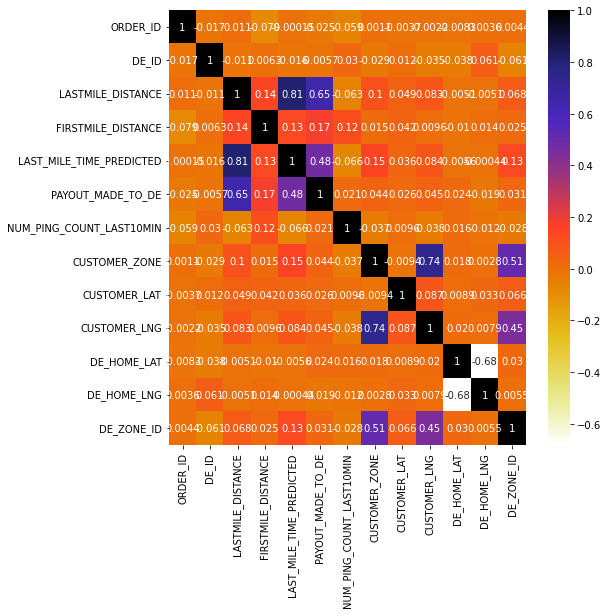

In [14]:
import seaborn as sns
#Using Pearson Correlation
plt.figure(figsize=(8,8))
cor = df_final.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [ ]:
zone=df_final['CUSTOMER_ZONE']-df_final['DE_ZONE_ID']

In [ ]:
df_final['CUSTOMER_ZONE'].value_counts()

375.0    26945
372.0    20808
624.0    17636
373.0    14621
841.0    14518
374.0    12380
668.0     6935
382.0       10
Name: CUSTOMER_ZONE, dtype: int64

In [ ]:
#haversine distance between the partner and agent

from math import radians, cos, sin, asin, sqrt
def dist(lat1, long1, lat2, long2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lat1, long1, lat2, long2 = map(radians, [lat1, long1, lat2, long2])
    # haversine formula 
    dlon = long2 - long1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km


In [ ]:
for ind,row in df_final.iterrows():
  lat1=row['CUSTOMER_LAT']
  long1=row['CUSTOMER_LNG']
  lat2=row['DE_HOME_LAT']
  long2=row['DE_HOME_LNG']
  df_final['distance']=dist(lat1,long1,lat2,long2)

In [ ]:
df_final.head()

,ORDER_ID,DE_ID,ASSIGNMENT_START_TIME,ASSIGNMENT_END_TIME,reject_type,PLACED_TIME,DELIVERED_TIME,LASTMILE_DISTANCE,FIRSTMILE_DISTANCE,LAST_MILE_TIME_PREDICTED,PAYOUT_MADE_TO_DE,NUM_PING_COUNT_LAST10MIN,LAST_PING_TIME_LAST10MIN,CUSTOMER_ZONE,CUSTOMER_LAT,CUSTOMER_LNG,SHIFT_END_TIME,DE_HOME_LAT,DE_HOME_LNG,DE_ZONE_ID,distance
0,2745,180976,2021-02-13 03:08:24.000,2021-02-13 03:38:26.000,NaN,2021-02-13 03:01:11.686,2021-02-13 03:43:26.000,320.9,320.0,314.0,1810.0,63,2021-02-13 03:07:34.000,373.0,37.377569,72.832560,05:42,37.374634,72.871986,373,2.044683
1,14974,180976,2021-02-15 03:36:24.000,2021-02-15 03:54:31.000,NaN,2021-02-15 03:30:24.093,2021-02-15 03:59:31.000,370.4,414.5,378.2,3710.0,52,2021-02-15 03:36:19.000,373.0,37.368782,72.809458,05:42,37.374634,72.871986,373,2.044683
2,115325,180976,2021-03-04 04:57:21.000,2021-03-04 05:23:19.000,NaN,2021-03-04 04:47:34.977,2021-03-04 05:28:19.000,408.2,320.0,397.2,2760.0,9,2021-03-04 04:56:33.000,373.0,37.374205,72.827956,05:42,37.374634,72.871986,373,2.044683
3,1648,180976,2021-02-13 00:12:40.000,2021-02-13 01:02:36.000,NaN,2021-02-13 00:11:09.582,2021-02-13 01:07:36.000,389.6,342.8,382.5,2210.0,16,2021-02-13 00:12:27.000,373.0,37.369154,72.815318,05:42,37.374634,72.871986,373,2.044683
4,72496,180976,2021-02-25 04:08:34.000,2021-02-25 04:30:31.000,NaN,2021-02-25 03:56:48.521,2021-02-25 04:35:31.000,392.3,418.1,351.3,2460.0,13,2021-02-25 04:07:58.000,373.0,37.376896,72.834044,05:42,37.374634,72.871986,373,2.044683


In [ ]:
df_final_new=df_final.drop(['DE_HOME_LAT','DE_HOME_LNG','CUSTOMER_LAT','CUSTOMER_LNG','CUSTOMER_ZONE','DE_ZONE_ID','DELIVERED_TIME'],axis=1)


In [ ]:
df_final_new.head()

,ORDER_ID,DE_ID,ASSIGNMENT_START_TIME,ASSIGNMENT_END_TIME,reject_type,PLACED_TIME,LASTMILE_DISTANCE,FIRSTMILE_DISTANCE,LAST_MILE_TIME_PREDICTED,PAYOUT_MADE_TO_DE,NUM_PING_COUNT_LAST10MIN,LAST_PING_TIME_LAST10MIN,SHIFT_END_TIME,distance
0,2745,180976,2021-02-13 03:08:24.000,2021-02-13 03:38:26.000,NaN,2021-02-13 03:01:11.686,320.9,320.0,314.0,1810.0,63,2021-02-13 03:07:34.000,05:42,2.044683
1,14974,180976,2021-02-15 03:36:24.000,2021-02-15 03:54:31.000,NaN,2021-02-15 03:30:24.093,370.4,414.5,378.2,3710.0,52,2021-02-15 03:36:19.000,05:42,2.044683
2,115325,180976,2021-03-04 04:57:21.000,2021-03-04 05:23:19.000,NaN,2021-03-04 04:47:34.977,408.2,320.0,397.2,2760.0,9,2021-03-04 04:56:33.000,05:42,2.044683
3,1648,180976,2021-02-13 00:12:40.000,2021-02-13 01:02:36.000,NaN,2021-02-13 00:11:09.582,389.6,342.8,382.5,2210.0,16,2021-02-13 00:12:27.000,05:42,2.044683
4,72496,180976,2021-02-25 04:08:34.000,2021-02-25 04:30:31.000,NaN,2021-02-25 03:56:48.521,392.3,418.1,351.3,2460.0,13,2021-02-25 04:07:58.000,05:42,2.044683


In [ ]:
df_final_new['ASSIGNMENT_START_TIME'] = pd.to_datetime(df_final_new['ASSIGNMENT_START_TIME'])
df_final_new['ASSIGNMENT_START_TIME_hour'] = df_final_new['ASSIGNMENT_START_TIME'].dt.hour
df_final_new['ASSIGNMENT_START_TIME_min'] = df_final_new['ASSIGNMENT_START_TIME'].dt.minute
df_final_new=df_final_new.drop(['ASSIGNMENT_START_TIME'],axis=1)





In [ ]:
df_final_new=df_final_new.drop(['ORDER_ID','DE_ID','reject_type'],axis=1)

In [ ]:
df_final_new.head()

,ASSIGNMENT_END_TIME,PLACED_TIME,LASTMILE_DISTANCE,FIRSTMILE_DISTANCE,LAST_MILE_TIME_PREDICTED,PAYOUT_MADE_TO_DE,NUM_PING_COUNT_LAST10MIN,LAST_PING_TIME_LAST10MIN,SHIFT_END_TIME,distance,ASSIGNMENT_START_TIME_hour,ASSIGNMENT_START_TIME_min
0,2021-02-13 03:38:26.000,2021-02-13 03:01:11.686,320.9,320.0,314.0,1810.0,63,2021-02-13 03:07:34.000,05:42,2.044683,3,8
1,2021-02-15 03:54:31.000,2021-02-15 03:30:24.093,370.4,414.5,378.2,3710.0,52,2021-02-15 03:36:19.000,05:42,2.044683,3,36
2,2021-03-04 05:23:19.000,2021-03-04 04:47:34.977,408.2,320.0,397.2,2760.0,9,2021-03-04 04:56:33.000,05:42,2.044683,4,57
3,2021-02-13 01:02:36.000,2021-02-13 00:11:09.582,389.6,342.8,382.5,2210.0,16,2021-02-13 00:12:27.000,05:42,2.044683,0,12
4,2021-02-25 04:30:31.000,2021-02-25 03:56:48.521,392.3,418.1,351.3,2460.0,13,2021-02-25 04:07:58.000,05:42,2.044683,4,8


In [ ]:
df_final_new['ASSIGNMENT_END_TIME'] = pd.to_datetime(df_final_new['ASSIGNMENT_END_TIME'])
df_final_new['ASSIGNMENT_END_TIME_hour'] = df_final_new['ASSIGNMENT_END_TIME'].dt.hour
df_final_new['ASSIGNMENT_END_TIME_min'] = df_final_new['ASSIGNMENT_END_TIME'].dt.minute
df_final_new=df_final_new.drop(['ASSIGNMENT_END_TIME'],axis=1)


In [ ]:
df_final_new['PLACED_TIME'] = pd.to_datetime(df_final_new['PLACED_TIME'])
df_final_new['PLACED_TIME_hour'] = df_final_new['PLACED_TIME'].dt.hour
df_final_new['PLACED_TIME_min'] = df_final_new['PLACED_TIME'].dt.minute
df_final_new=df_final_new.drop(['PLACED_TIME'],axis=1)

In [ ]:
df_final_new['LAST_PING_TIME_LAST10MIN'] = pd.to_datetime(df_final_new['LAST_PING_TIME_LAST10MIN'])
df_final_new['LAST_PING_TIME_LAST10MIN_hour'] = df_final_new['LAST_PING_TIME_LAST10MIN'].dt.hour
df_final_new['LAST_PING_TIME_LAST10MIN_min'] = df_final_new['LAST_PING_TIME_LAST10MIN'].dt.minute
df_final_new=df_final_new.drop(['LAST_PING_TIME_LAST10MIN'],axis=1)

In [ ]:
import time
for ind,row in df_final.iterrows():
  df_final_new['SHIFT_END_TIME_hour']=time.strptime(row['SHIFT_END_TIME'],"%H:%M").tm_hour
  df_final_new['SHIFT_END_TIME_min']=time.strptime(row['SHIFT_END_TIME'],"%H:%M").tm_min




In [ ]:
df_final_new['SHIFT_END_TIME'].value_counts()

05:42    63431
06:42    32739
01:42    12746
11:42    10864
08:42    10860
00:42     1754
Name: SHIFT_END_TIME, dtype: int64

In [ ]:
df_final_new.head()

,LASTMILE_DISTANCE,FIRSTMILE_DISTANCE,LAST_MILE_TIME_PREDICTED,PAYOUT_MADE_TO_DE,NUM_PING_COUNT_LAST10MIN,SHIFT_END_TIME,distance,ASSIGNMENT_START_TIME_hour,ASSIGNMENT_START_TIME_min,ASSIGNMENT_END_TIME_hour,ASSIGNMENT_END_TIME_min,PLACED_TIME_hour,PLACED_TIME_min,LAST_PING_TIME_LAST10MIN_hour,LAST_PING_TIME_LAST10MIN_min,SHIFT_END_TIME_hour,SHIFT_END_TIME_min
0,320.9,320.0,314.0,1810.0,63,05:42,2.044683,3,8,3,38,3,1,3,7,6,42
1,370.4,414.5,378.2,3710.0,52,05:42,2.044683,3,36,3,54,3,30,3,36,6,42
2,408.2,320.0,397.2,2760.0,9,05:42,2.044683,4,57,5,23,4,47,4,56,6,42
3,389.6,342.8,382.5,2210.0,16,05:42,2.044683,0,12,1,2,0,11,0,12,6,42
4,392.3,418.1,351.3,2460.0,13,05:42,2.044683,4,8,4,30,3,56,4,7,6,42


In [ ]:
df_final_new.shape

(132394, 17)

In [ ]:
df_final_new['SHIFT_END_TIME_hour'] = pd.to_datetime(df_final_new['SHIFT_END_TIME'], format='%H:%M').dt.hour
df_final_new['SHIFT_END_TIME_min'] = pd.to_datetime(df_final_new['SHIFT_END_TIME'], format='%H:%M').dt.minute

In [ ]:
df_final_new=df_final_new.drop(['SHIFT_END_TIME'],axis=1)

In [ ]:
df_final_new.head()

,LASTMILE_DISTANCE,FIRSTMILE_DISTANCE,LAST_MILE_TIME_PREDICTED,PAYOUT_MADE_TO_DE,NUM_PING_COUNT_LAST10MIN,distance,ASSIGNMENT_START_TIME_hour,ASSIGNMENT_START_TIME_min,ASSIGNMENT_END_TIME_hour,ASSIGNMENT_END_TIME_min,PLACED_TIME_hour,PLACED_TIME_min,LAST_PING_TIME_LAST10MIN_hour,LAST_PING_TIME_LAST10MIN_min,SHIFT_END_TIME_hour,SHIFT_END_TIME_min
0,320.9,320.0,314.0,1810.0,63,2.044683,3,8,3,38,3,1,3,7,5,42
1,370.4,414.5,378.2,3710.0,52,2.044683,3,36,3,54,3,30,3,36,5,42
2,408.2,320.0,397.2,2760.0,9,2.044683,4,57,5,23,4,47,4,56,5,42
3,389.6,342.8,382.5,2210.0,16,2.044683,0,12,1,2,0,11,0,12,5,42
4,392.3,418.1,351.3,2460.0,13,2.044683,4,8,4,30,3,56,4,7,5,42


In [ ]:
np.any(np.isnan(df_final_new))

True

In [ ]:
np.all(np.isfinite(df_final_new))

False

In [ ]:
df_final_new.isnull().sum()

LASTMILE_DISTANCE                0
FIRSTMILE_DISTANCE               0
LAST_MILE_TIME_PREDICTED         0
PAYOUT_MADE_TO_DE                3
NUM_PING_COUNT_LAST10MIN         0
distance                         0
ASSIGNMENT_START_TIME_hour       0
ASSIGNMENT_START_TIME_min        0
ASSIGNMENT_END_TIME_hour         0
ASSIGNMENT_END_TIME_min          0
PLACED_TIME_hour                 0
PLACED_TIME_min                  0
LAST_PING_TIME_LAST10MIN_hour    0
LAST_PING_TIME_LAST10MIN_min     0
SHIFT_END_TIME_hour              0
SHIFT_END_TIME_min               0
dtype: int64

In [ ]:
df_final_new['PAYOUT_MADE_TO_DE'].fillna(value=df_final_new['PAYOUT_MADE_TO_DE'].mean(), inplace=True)

In [ ]:
import pandas as pd
import numpy as np
  #target column i.e price range
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model_feature = ExtraTreesClassifier()
model_feature.fit(df_final,target)
print(model_feature.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model_feature.feature_importances_, index=df_final_new.columns)
feat_importances.nlargest(35).plot(kind='barh')

plt.show()

In [ ]:
# use it later
#df_features=df_final_new.drop(['SHIFT_END_TIME_min','distance'],axis=1)

In [ ]:
df_features.columns

Index(['LASTMILE_DISTANCE', 'FIRSTMILE_DISTANCE', 'LAST_MILE_TIME_PREDICTED',
       'PAYOUT_MADE_TO_DE', 'NUM_PING_COUNT_LAST10MIN',
       'ASSIGNMENT_START_TIME_hour', 'ASSIGNMENT_START_TIME_min',
       'ASSIGNMENT_END_TIME_hour', 'ASSIGNMENT_END_TIME_min',
       'PLACED_TIME_hour', 'PLACED_TIME_min', 'LAST_PING_TIME_LAST10MIN_hour',
       'LAST_PING_TIME_LAST10MIN_min', 'SHIFT_END_TIME_hour'],
      dtype='object')

In [ ]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(df_final_new,target, test_size=0.35, random_state=1) 

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(86056, 16)
(86056,)
(46338, 16)


Decision tree classifier 

In [ ]:
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 1.0


In [ ]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = df_final_new.columns,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('diabetes.png')
Image(graph.create_png())

Random forest classifier feature selection


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
#Create a Gaussian Classifier
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)

#Train the model using the training sets y_pred=clf.predict(X_test)



SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=None,
                                                 oob_score=False,

In [ ]:
sel.get_support()

array([False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False])

# After rejecting features and keeping only payout

In [ ]:
selected_feat= X_train.columns[(sel.get_support())]
selected_feat

Index(['PAYOUT_MADE_TO_DE'], dtype='object')

In [ ]:
df_pay=pd.DataFrame(df_final_new['PAYOUT_MADE_TO_DE'])
df_pay.head()

,PAYOUT_MADE_TO_DE
0,1810.0
1,3710.0
2,2760.0
3,2210.0
4,2460.0


In [ ]:
X_train_pay, X_test_pay, y_train_pay, y_test_pay = train_test_split(df_pay,target, test_size=0.30, random_state=1) 

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm_pay = MinMaxScaler().fit(X_train_pay)

# transform training data
X_train_norm_pay = norm_pay.transform(X_train_pay)

# transform testing dataabs
X_test_norm_pay = norm_pay.transform(X_test_pay)

In [ ]:
from sklearn import svm

#Create a svm Classifier
clf_svm_pay= svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf_svm_pay.fit(X_train_norm_pay, y_train_pay)

#Predict the response for test dataset
y_pred_pay= clf_svm_pay.predict(X_test_norm_pay)



# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test_pay, y_pred_pay))

Accuracy: 1.0


#Not rejecting features

In [ ]:
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(X_train)

# transform training data
X_train_norm = norm.transform(X_train)

# transform testing dataabs
X_test_norm = norm.transform(X_test)

SVM

In [ ]:
from sklearn import svm

#Create a svm Classifier
clf_svm= svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf_svm.fit(X_train_norm, y_train)

#Predict the response for test dataset
y_pred = clf_svm.predict(X_test_norm)



# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 1.0


XGB Classifier

In [ ]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
# fit model no training data
model_xg = XGBClassifier()
model_xg.fit(X_train_norm, y_train)
# make predictions for test data
y_pred_xg = model_xg.predict(X_test_norm)
predictions_xg = [round(value) for value in y_pred_xg]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions_xg)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 100.00%


In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

Nueral Networks to remove overfitting

In [ ]:
model = Sequential()
model.add(Dense(1024, input_dim=16, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_norm, y_train, epochs=100, batch_size=64,validation_data=(X_test_norm,y_test),shuffle=True,callbacks=[es,mc])

Epoch 1/100


Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7fe31e274050>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


1655/1655 [==============================] - 66s 21ms/step - loss: 0.0595 - accuracy: 0.9858 - val_loss: 0.0303 - val_accuracy: 0.9892
Epoch 2/100
1655/1655 [==============================] - 36s 22ms/step - loss: 0.0051 - accuracy: 0.9991 - val_loss: 0.6451 - val_accuracy: 0.8506
Epoch 3/100
1655/1655 [==============================] - 35s 21ms/step - loss: 0.0047 - accuracy: 0.9990 - val_loss: 5.2429e-05 - val_accuracy: 1.0000
Epoch 4/100
1655/1655 [==============================] - 35s 21ms/step - loss: 0.0019 - accuracy: 0.9997 - val_loss: 2.2282e-05 - val_accuracy: 1.0000
Epoch 5/100
1655/1655 [==============================] - 35s 21ms/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 1.0863e-05 - val_accuracy: 1.0000
Epoch 6/100
1655/1655 [==============================] - 36s 22ms/step - loss: 5.6307e-05 - accuracy: 1.0000 - val_loss: 2.9887e-06 - val_accuracy: 1.0000
Epoch 7/100
1655/1655 [==============================] - 36s 22ms/step - loss: 3.6191e-05 - accuracy: 1.0000 -

In [ ]:
df_final_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132394 entries, 0 to 132393
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   ORDER_ID                    132394 non-null  int64         
 1   DE_ID                       132394 non-null  int64         
 2   ASSIGNMENT_START_TIME       132394 non-null  datetime64[ns]
 3   ASSIGNMENT_END_TIME         132394 non-null  object        
 4   reject_type                 8048 non-null    object        
 5   PLACED_TIME                 132394 non-null  object        
 6   LASTMILE_DISTANCE           132394 non-null  float64       
 7   FIRSTMILE_DISTANCE          132394 non-null  float64       
 8   LAST_MILE_TIME_PREDICTED    132394 non-null  float64       
 9   PAYOUT_MADE_TO_DE           132391 non-null  float64       
 10  NUM_PING_COUNT_LAST10MIN    132394 non-null  int64         
 11  LAST_PING_TIME_LAST10MIN    132394 non-

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 1024)              17408     
_________________________________________________________________
batch_normalization_6 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_15 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)               1024      
_________________________________________________________________
dense_17 (Dense)             (None, 128)              

In [ ]:
df_assign.shape

(0, 21)